In [23]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [3]:
len(word2idx)

445881

In [4]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [6]:
conditions = data.link_anchor.str.contains('#', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

In [7]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [8]:
data.shape

(2459381, 7)

In [9]:
# with open('../data/sample_doc2vec_data.pkl', 'rb') as f:
#     docs = pickle.load(f)

In [10]:
# with open('../data/sample_labels.pkl', 'rb') as f:
#     data = pickle.load(f)

In [11]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [12]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [13]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [14]:
id2idx = {value: key for key, value in idx2id.items()}

In [15]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [17]:
graph_embedding.shape

(5850119, 250)

In [18]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [19]:
#window length actually 2 times this since from both sides
window_length = 10

In [26]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

lstm_input = []
graph_input = []
# doc_input = []
response = []
not_in_graph = []
for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
    text = article['text']
#     doc_embedding = docs[i][0]
#     for entity, indices in article[1].items():
    name = article['link_anchor']
    entity_id = article['target_wikidata']
    #Don't include actual entity text for now in context window since doing fixed length? 
    indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
    entity_idx = np.where(indices == 1)[0]
    if len(entity_idx):
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                  split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        #if word not in vocab, by default map to 1
        context_word2idx = [word2idx.get(word, 1) for word in context]
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        if not pd.isnull(article['candidates']):
            candidates_list = ast.literal_eval(article['candidates'])[:10]
            #can't choose actual entity as false 
            if entity_id in candidates_list:
                candidates_list.remove(entity_id)
            if len(candidates_list) > 0:
                for false_entity_id in candidates_list:
                    if false_entity_id in id2idx:
                        false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                        lstm_input.append(context_word2idx)
                        graph_input.append(false_graph_embed)
        #                 doc_input.append(doc_embedding)
                        response.append(0)
                    else:
                        not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            lstm_input.append(context_word2idx)
            graph_input.append(true_graph_embed)
    #         doc_input.append(doc_embedding)
            response.append(1)
        else:
            not_in_graph.append(entity_id)
            
lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
graph_input = np.array(graph_input)
# doc_input = np.array(doc_input)
response = np.array(response)

NameError: name 'doc_input' is not defined

In [29]:
np.save("../data/model1/lstm_input.pkl", lstm_input)
np.save("../data/model1/graph_input.pkl", graph_input)
np.save("../data/model1/response.pkl", response)

In [ ]:
lstm_input = np.load("../data/model1/lstm_input.pkl")
graph_input = np.load("../data/model1/graph_input.pkl")
response = np.load("../data/model1/response.pkl")

In [31]:
len(graph_input)

11793058

In [32]:
len(lstm_input)

11793058

In [33]:
len(response)

11793058

In [34]:
response.mean()

0.199529672456457

In [35]:
len(not_in_graph)

385945

In [36]:
len(not_in_graph) / len(graph_input)

0.03272645653061318

In [21]:
np.random.seed(1)

train_ind, test_ind = train_test_split(np.arange(len(response)))
lstm_train = lstm_input[train_ind]
lstm_test = lstm_input[test_ind]
graph_train = graph_input[train_ind]
graph_test = graph_input[test_ind]
# doc_train = doc_input[train_ind]
# doc_test = doc_input[test_ind]
y_train = response[train_ind]
y_test = response[test_ind]

len(y_train), len(y_test)

(8844793, 2948265)

In [24]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)

In [33]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=150, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
embed = Dropout(rate = 0.2)(embed)
out1 = LSTM(256)(embed)
w = concatenate([out1, inp2])
w = Dropout(0.2)(w)
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 20, 150)      66882150    input_15[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 20, 150)      0           embedding_8[0][0]                
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 256)          416768      dropout_19[0][0]                 
__________________________________________________________________________________________________
input_16 (

In [34]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4
7075834/7075834 [==============================] - 439s 62us/step - loss: 0.4146 - acc: 0.8212 - val_loss: 0.3618 - val_acc: 0.8398
Epoch 2/4
7075834/7075834 [==============================] - 434s 61us/step - loss: 0.3610 - acc: 0.8398 - val_loss: 0.3346 - val_acc: 0.8509
Epoch 3/4
7075834/7075834 [==============================] - 434s 61us/step - loss: 0.3325 - acc: 0.8508 - val_loss: 0.3258 - val_acc: 0.8553
Epoch 4/4
7075834/7075834 [==============================] - 434s 61us/step - loss: 0.3114 - acc: 0.8599 - val_loss: 0.3219 - val_acc: 0.8567


In [35]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8570016602985145

In [38]:
cm = confusion_matrix(y_test, y_test_pred)

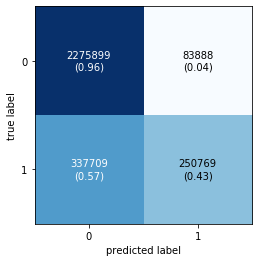

In [39]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [40]:
model.save('../data/model1/model.h5')

np.save("../data/model1/lstm_train", lstm_train)
np.save("../data/model1/lstm_iest", lstm_test)

np.save("../data/model1/graph_train", graph_train)
np.save("../data/model1/graph_test", graph_test)

np.save("../data/model1/y_train", y_train)
np.save("../data/model1/y_test", y_test)

In [43]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8106025068981249

In [44]:
cm = confusion_matrix(y_test, y_test_pred)

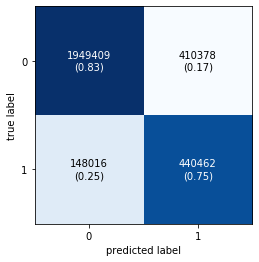

In [45]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);